In [1]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn

import numpy as np

In [3]:
config_file_path = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [4]:
dconfig = config['data']
train_data, val_data, test_data = get_data_loaders(**dconfig)

In [5]:
DEVICE = 'cuda:1'
# α=0.7
checkpoint_file = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/checkpoints/model_checkpoint_016.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention(
  (_layers): ModuleList(
    (0): Bipartite_Layers(
      (enc): ModuleList(
        (0): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=37, out_features=128, bias=True)
            (fc_k): Linear(in_features=37, out_features=128, bias=True)
            (fc_v): Linear(in_features=37, out_features=128, bias=True)
            (fc_o): Linear(in_features=128, out_features=128, bias=True)
            (ln0): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
            (ln1): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
          )
        )
        (1): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=128, out_features=128, bias=True)
            (fc_k): Linear(in_features=128, out_features=128, bias=True)
            (fc_v): Linear(in_features=128, out_features=128, bias=True)
            (f

In [6]:
dconfig['name']

'gt-trkvec-masked'

In [7]:
dconfig['load_complete_graph']

False

In [8]:
val_data.dataset.dataset.phi = 1
val_data.dataset.dataset.z = 0

In [9]:
next(iter(val_data))

BatchInfo(track_vector=tensor([[[ -2.0810,  -1.6294,  -5.4184,  ...,   1.0000,   1.0000,   2.0000],
         [ -2.4503,   1.2079,  -3.3634,  ...,   1.0000,   1.0000,   1.0000],
         [  0.1748,  -2.7284,  -7.1221,  ...,   1.0000,   1.0000,   1.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ -1.5425,  -1.9447, -12.7866,  ...,   1.0000,   1.0000,   1.0000],
         [  2.1985,  -1.1091,  -2.6193,  ...,   1.0000,   0.0000,   0.0000],
         [ -2.3931,  -0.7638,   6.1299,  ...,   1.0000,   1.0000,   1.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ -2.4917,  

In [16]:
N_BATCHES = 40
all_preds = []
all_preds_prob = []
all_correct = []
for phi in np.linspace(0, 2*np.pi, 40):
    preds = []
    preds_prob = []
    correct = []
    val_data.dataset.dataset.phi = phi
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)

In [18]:
accs_gt = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

In [19]:
accs_gt

array([0.90356445, 0.90332031, 0.90175781, 0.90180664, 0.90166016,
       0.90043945, 0.896875  , 0.89086914, 0.88061523, 0.8690918 ,
       0.86728516, 0.87675781, 0.88793945, 0.89296875, 0.89643555,
       0.89799805, 0.89941406, 0.89975586, 0.90014648, 0.90029297,
       0.90087891, 0.90136719, 0.90068359, 0.89941406, 0.89873047,
       0.89658203, 0.89414063, 0.88710937, 0.87299805, 0.86313477,
       0.86879883, 0.8824707 , 0.89223633, 0.89663086, 0.89902344,
       0.90175781, 0.90292969, 0.9027832 , 0.90322266, 0.90356445])

Text(0.5, 1.0, 'Effects of Rotation on Accuracy')

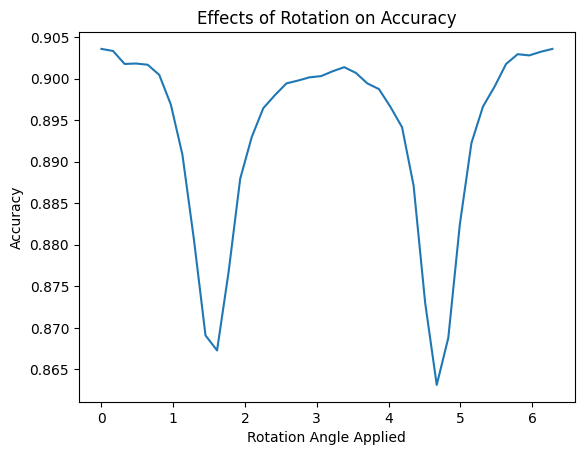

In [21]:
plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt)
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy")

In [13]:
N_BATCHES = 40
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = 0
for z in np.linspace(-20, 20, 40):
    preds = []
    preds_prob = []
    correct = []
    val_data.dataset.dataset.z = z
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_gt = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy')

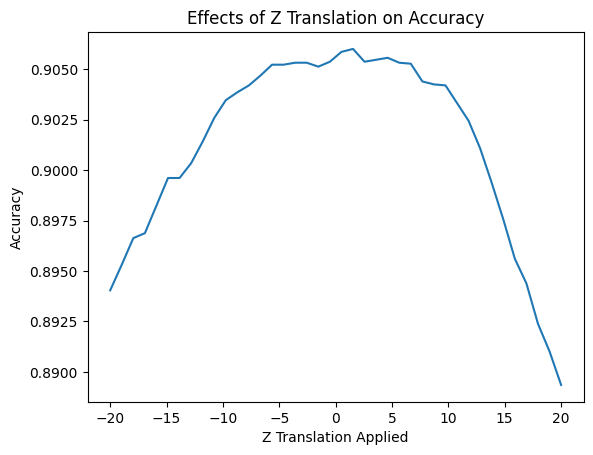

In [17]:
plt.plot(np.linspace(-20, 20, 40), accs_gt)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy")